In [59]:
# I referrer to http://ailaby.com/least_square/
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2

from PIL import Image

HEIGHT = 170
WIDTH = 256

In [71]:
def cv2_to_pltshow(in_img):
    blue = in_img[:, :, 0]
    green = in_img[:, :, 1]
    red = in_img[:, :, 2]
    
    out_img = np.zeros_like(in_img)
    out_img[:, :, 0] = red
    out_img[:, :, 1] = green
    out_img[:, :, 2] = blue
    out_img = out_img * 255
    out_img = out_img.astype(np.uint8)
    
    return out_img

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


True

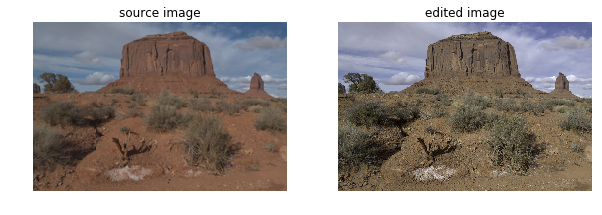

In [75]:
# show and load image
def image_loader(path):
#     img_pil = Image.open(path)
#     img_pil = img_pil.resize((WIDTH, HEIGHT))
#     img_np = np.asarray(img_pil) / 255.0
#     print(img_np.shape)
    
#     if img_np.shape[2] > 3:
#         img_np = img_np[:,:,0:3]
    
#     return img_np
    
    img = cv2.imread(path)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img / 255.0
    
    return img

from_dir = "./input_images"

src_file = "source.png"
edited_file = "edited3.tif"
src_img = image_loader(from_dir+"/"+src_file)
edited_img = image_loader(from_dir+"/"+edited_file)

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(10, 10))

ax0.imshow(cv2_to_pltshow(src_img))
ax0.set_title('source image')
ax0.axis('off')

ax1.imshow(cv2_to_pltshow(edited_img))
ax1.set_title('edited image')
ax1.axis('off')

fig.show()

out_dir = "./output_images"
cv2.imwrite(out_dir+"/"+src_file, np.uint8(src_img*255))
cv2.imwrite(out_dir+"/"+edited_file, np.uint8(edited_img*255))

In [51]:
def make_set(src, edited):
    sort_index = np.argsort(src)
    src = np.reshape(src[sort_index], (src.shape[0], 1))
    edited = np.reshape(edited[sort_index], (edited.shape[0], 1))
    set_img = np.concatenate([src, edited], axis=1)
    
    return set_img

src_arr = np.reshape(src_img, (HEIGHT*WIDTH, 3))
edited_arr = np.reshape(edited_img, (HEIGHT*WIDTH, 3))

red = make_set(src_arr[:, 0], edited_arr[:, 0])
green = make_set(src_arr[:, 1], edited_arr[:, 1])
blue = make_set(src_arr[:, 2], edited_arr[:, 2])

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


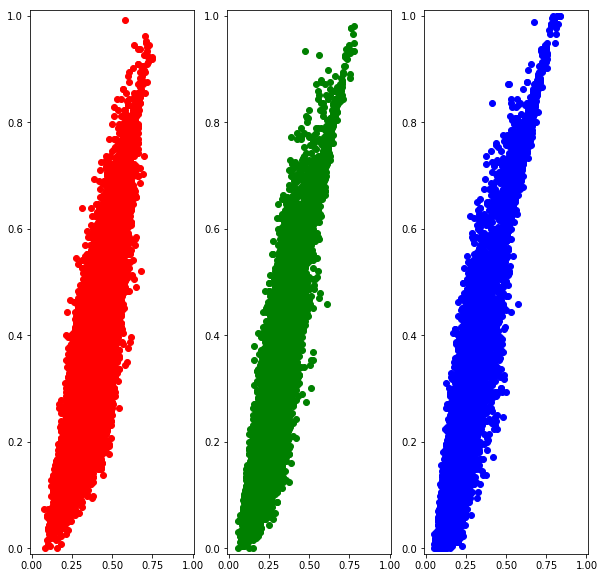

In [52]:
# show row data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax0.scatter(red[:, 0], red[:, 1], color='red')
ax0.set_xlim(-0.01, 1.01)
ax0.set_ylim(-0.01, 1.01)

ax1.scatter(green[:, 0], green[:, 1], color='green')
ax1.set_xlim(-0.01, 1.01)
ax1.set_ylim(-0.01, 1.01)

ax2.scatter(blue[:, 0], blue[:, 1], color='blue')
ax2.set_xlim(-0.01, 1.01)
ax2.set_ylim(-0.01, 1.01)

fig.show()

In [53]:
# fit tone curve
weights = [np.polyfit(red[:, 0], red[:, 1], 4),
           np.polyfit(green[:, 0], green[:, 1], 4),
           np.polyfit(blue[:, 0], blue[:, 1], 4)]

y_fit = [np.poly1d(weights[0])(red[:, 0]),
         np.poly1d(weights[1])(green[:, 0]),
         np.poly1d(weights[2])(blue[:, 0])]

In [54]:
# adjust for uint8 
for c in range(len(y_fit)):
    for iter in range(len(y_fit[c])):
        if y_fit[c][iter] > 1.0:
            y_fit[c][iter] = 1.0
        elif y_fit[c][iter] < 0:
            y_fit[c][iter] = 0
        
print(y_fit[0])

[ 0.          0.          0.0192513  ...,  0.8508283   0.86676783
  0.86676783]


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


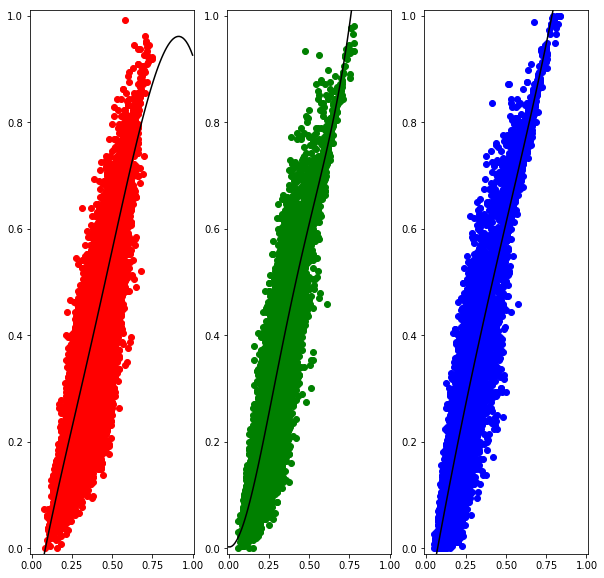

In [55]:
# show tone curve
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

x = np.linspace(0, 1, 100)
ax0.scatter(red[:, 0], red[:, 1], color='red')
ax0.plot(x, np.poly1d(weights[0])(x), color='black')
ax0.set_xlim(-0.01, 1.01)
ax0.set_ylim(-0.01, 1.01)

ax1.scatter(green[:, 0], green[:, 1], color='green')
ax1.plot(x, np.poly1d(weights[1])(x), 'black')
ax1.set_xlim(-0.01, 1.01)
ax1.set_ylim(-0.01, 1.01)

ax2.scatter(blue[:, 0], blue[:, 1], color='blue')
ax2.plot(x, np.poly1d(weights[2])(x), color='black')
ax2.set_xlim(-0.01, 1.01)
ax2.set_ylim(-0.01, 1.01)

fig.show()

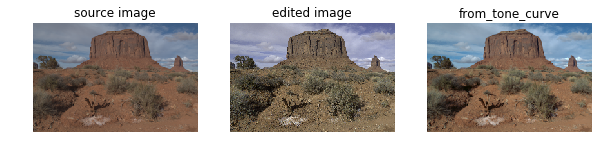

In [56]:
# by poly
out_np = np.zeros_like(src_img)

for c in range(3):
    tmp = np.poly1d(weights[c])(src_arr[:, c])
    out_np[:, :, c] = np.reshape(tmp, (out_np.shape[0], out_np.shape[1]))
    
out_np = out_np * 255
# adjust for uint8 
for y in range(out_np.shape[0]):
    for x in range(out_np.shape[1]):
        for c in range(out_np.shape[2]):
            if out_np[y,x,c] > 255:
                out_np[y,x,c] = 255
            elif out_np[y,x,c] < 0:
                out_np[y,x,c] = 0
    
out_pil = Image.fromarray(np.uint8(out_np))
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(10, 10))
ax0.imshow(src_img)
ax0.set_title('source image')
ax0.axis('off')

ax1.imshow(edited_img)
ax1.set_title('edited image')
ax1.axis('off')

ax2.imshow(out_pil)
ax2.set_title('from_tone_curve')
ax2.axis('off')

out_pil.save('./output_images/by-poly_'+edited_file)

In [44]:
# fitting by SVR
from sklearn.svm import SVR

svr_rbf = [SVR(kernel='rbf', C=1e3, gamma=0.1),
           SVR(kernel='rbf', C=1e3, gamma=0.1),
           SVR(kernel='rbf', C=1e3, gamma=0.1)]

svr_rbf[0].fit(red[:,0].reshape(red.shape[0], 1), red[:, 1])
svr_rbf[1].fit(green[:,0].reshape(green.shape[0], 1), green[:, 1])
svr_rbf[2].fit(blue[:,0].reshape(blue.shape[0], 1), blue[:, 1])

y_rbf = [svr_rbf[0].predict(red[:,0].reshape(red.shape[0], 1)),
         svr_rbf[1].predict(green[:,0].reshape(green.shape[0], 1)),
         svr_rbf[2].predict(blue[:,0].reshape(green.shape[0], 1))]

In [45]:
# adjust for uint8 
for c in range(len(y_rbf)):
    for iter in range(len(y_rbf[c])):
        if y_rbf[c][iter] > 1.0:
            y_rbf[c][iter] = 1.0
        elif y_rbf[c][iter] < 0:
            y_rbf[c][iter] = 0

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


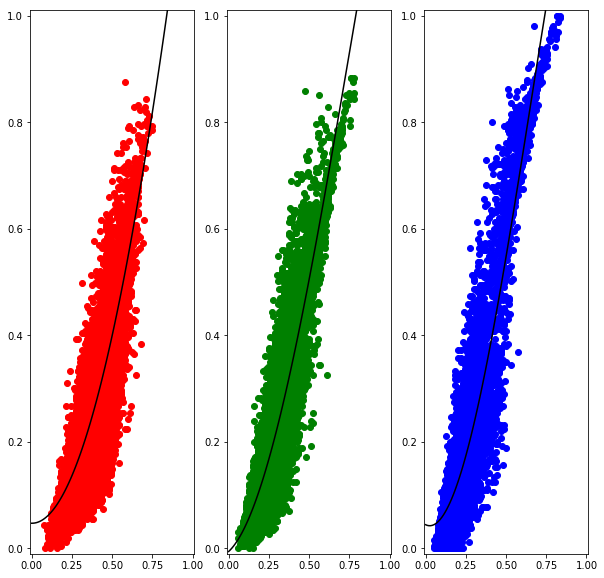

In [47]:
# show tone curve by SVR
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

x = np.linspace(0, 1, 100)
x = np.reshape(x, (len(x), 1))
ax0.scatter(red[:, 0], red[:, 1], color='red')
ax0.plot(x, svr_rbf[0].predict(x) , color='black')
ax0.set_xlim(-0.01, 1.01)
ax0.set_ylim(-0.01, 1.01)

ax1.scatter(green[:, 0], green[:, 1], color='green')
ax1.plot(x, svr_rbf[1].predict(x), 'black')
ax1.set_xlim(-0.01, 1.01)
ax1.set_ylim(-0.01, 1.01)

ax2.scatter(blue[:, 0], blue[:, 1], color='blue')
ax2.plot(x, svr_rbf[2].predict(x), color='black')
ax2.set_xlim(-0.01, 1.01)
ax2.set_ylim(-0.01, 1.01)

fig.show()

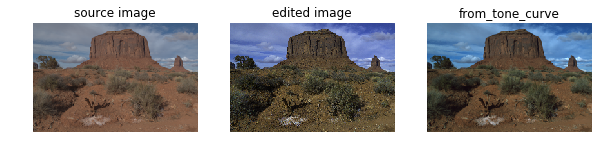

In [48]:
# by svr
out_np = np.zeros_like(src_img)

for c in range(3):
    tmp = svr_rbf[c].predict(src_arr[:, c].reshape(src_arr.shape[0], 1))
    out_np[:, :, c] = np.reshape(tmp, (out_np.shape[0], out_np.shape[1])) 
    
out_np = out_np * 255
# adjust for uint8 
for y in range(out_np.shape[0]):
    for x in range(out_np.shape[1]):
        for c in range(out_np.shape[2]):
            if out_np[y,x,c] > 255:
                out_np[y,x,c] = 255
            elif out_np[y,x,c] < 0:
                out_np[y,x,c] = 0
    

out_pil = Image.fromarray(np.uint8(out_np))
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(10, 10))
ax0.imshow(src_img)
ax0.set_title('source image')
ax0.axis('off')

ax1.imshow(edited_img)
ax1.set_title('edited image')
ax1.axis('off')

ax2.imshow(out_pil)
ax2.set_title('from_tone_curve')
ax2.axis('off')

out_pil.save('./output_images/by-svr_'+edited_file)